In [1]:
import sys
sys.path.append('../modules/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pulp
from mymodule_2 import *
from mymodule2_2 import *
from pulp_func_2 import *
df2023_result = pd.read_excel('../excels/附件3/2023_result.xlsx')
# 去除列名末尾的空格。很奇怪
df2023_result.columns = [column.rstrip(' ') for column in df2023_result.columns]
# print(df2023_result)

In [2]:
# 数据准备

merged_df = get_merged_df(df21, df22)
# print(merged_df)
total_yield_2023 = merged_df.groupby(['作物编号', '作物名称'])['单地块类型总产量/斤'].sum().reset_index()
total_yield_2023.columns = ['作物编号', '作物名称', '总产量/斤']
# print(total_yield_2023)
expected_sales_data_2023 = total_yield_2023.copy()
expected_sales_data_2023.columns = ['作物编号', '作物名称', '预期销售量/斤']

# 按照 '作物编号' 和 '作物名称' 进行分组，并对 '利润' 进行求和
total_profit = merged_df.groupby(['作物编号', '作物名称'])[['利润', '每亩利润']].sum().reset_index()
# 重命名列，以便清晰地表示数据
total_profit.columns = ['作物编号', '作物名称', '总利润/元', '每亩总利润/元']
# 打印 total_profit
# print(total_profit)
total_profit_2023 = total_profit['总利润/元'].sum()
# print("总利润/元的和:", total_profit_2023)
std_devs = [0.005, 0.005, 0.01, 0.01, 0.003, 0.003, 0.003, 0.003]
past_profits = [total_profit_2023]

fields = create_fields(df11)
# for field in fields:
#     print(field)
new_fields = create_new_fields(fields)
# for field in new_fields:
#     print(field)

### 2 - 2024

In [5]:
mc = 3 # 蒙特卡洛模拟次数
scores = [total_profit_2023, 0, 0, 0, 0, 0, 0, 0] # 2023年到2030年的得分
profits = [total_profit_2023, 0, 0, 0, 0, 0, 0, 0] # 2023年到2030年的利润
weights = [0.7, 0.3] # 分数计算权重
k = 0.5
min_area_percent = 0.2
max_plots = 4
for i in range(mc): 
    # 每次蒙特卡洛模拟都要重新初始化数据
    expected_sales_data = total_yield_2023.copy() # 初始值为2023年的数据
    # print(expected_sales_data)
    expected_sales_data.columns = ['作物编号', '作物名称', '预期销售量/斤']
    crops = create_crops(df12, df22)
    # for crop in crops:
    #     print(crop)    
    # 2024年

    # 更新数据
    expected_sales_data = update_expected_sales_data(expected_sales_data, expected_sales_data_2023, std_devs)
    # print(expected_sales_data)
    crops = update_crops(crops, std_devs)
    # for crop in crops:
    #     print(crop)

    variables, binary_variables, actual_sales, excess_yield = create_variables(new_fields, crops)
    # 创建线性规划问题
    prob = pulp.LpProblem("Crop_Planting_Optimization", pulp.LpMaximize)
    # 定义目标函数的各个部分
    k = 0.5
    min_area_percent = 0.2
    max_plots = 4
    profit = define_objective_function(variables, actual_sales, excess_yield, crops, new_fields, k)
    # 将目标函数添加到问题中
    prob += profit
    # print(profit)
    prob = add_constraints2(prob, variables, binary_variables, actual_sales, excess_yield,
                            crops, new_fields, total_yield_2023, df2023_result, min_area_percent, max_plots)

    # 求解问题
    prob.solve()
    print("Status:", pulp.LpStatus[prob.status])
    update_new_fields(variables, new_fields)

    objective_value = pulp.value(prob.objective)
    print("Objective Function Value:", objective_value)
    past_profits.append(objective_value)
    stability = calculate_stability(past_profits)
    # print("Stability:", stability)
    score_now = calculate_score(objective_value, stability, weights)
    print("Score:", score_now)
    if scores[1] < score_now:
        scores[1] = score_now
        profits[1] = objective_value
        df_template = pd.read_excel('../excels/附件3/template.xlsx')
        output(df_template, 2024, new_fields, k)
    # print(df_template)
    # print("Scores:", scores)
    # 清空当年的种植信息
    for field in new_fields:
        field.planted_crop = []
        # print(field.planted_crop)

    # 2025年到2030年

    for year in range(2025, 2031):
        list = [k, min_area_percent, max_plots, year]
        expected_sales_data = update_expected_sales_data(expected_sales_data, expected_sales_data_2023, std_devs)
        crops = update_crops(crops, std_devs)

        df_last1_result = pd.read_excel(f'../excels/附件3/{year - 1}_result_{k}.xlsx')
        df_last1_result.columns = [column.rstrip(' ') for column in df_last1_result.columns]
        if year - 2 == 2023:
            df_last2_result = pd.read_excel(f'../excels/附件3/2023_result.xlsx')
        else:    
            df_last2_result = pd.read_excel(f'../excels/附件3/{year - 2}_result_{k}.xlsx')
        df_last2_result.columns = [column.rstrip(' ') for column in df_last2_result.columns]
        objective_value = optimize_planting_strategy(new_fields, crops, expected_sales_data, df_last1_result, df_last2_result, list)
        past_profits.append(objective_value)
        stability = calculate_stability(past_profits)
        score_now = calculate_score(objective_value, stability, weights)
        print("Score:", score_now)
        if scores[year - 2023] < score_now:
            scores[year - 2023] = score_now
            profits[year - 2023] = objective_value
            df_template = pd.read_excel('../excels/附件3/template.xlsx')
            output(df_template, year, new_fields, k)
        # 清空当年的种植信息
        for field in new_fields:
            field.planted_crop = []
    print("Scores:", scores)

Status: Infeasible
Objective Function Value: 8703228.322163457
Score: 5581018.6115566315


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8612993.93924471
Score: 5526951.78087185


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8865619.828873292
Score: 5712448.9789691875


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8964004.412361218
Score: 5789612.615674094


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 9983337.067919994
Score: 6508560.974095709


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 9438940.700625565
Score: 6133725.855138975


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 9250609.058120443
Score: 6008871.709373228


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Scores: [5926348.25, 5581018.6115566315, 5526951.78087185, 5712448.9789691875, 5789612.615674094, 6508560.974095709, 6133725.855138975, 6008871.709373228]
Status: Infeasible
Objective Function Value: 8718704.614606354
Score: 5642333.6938619185


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 9053492.43916172
Score: 5883139.615376461


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 8852845.872457549
Score: 5748813.1563484445


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: 9715773.74894025
Score: 6357328.258909505


e:\Users\Timothy\anaconda3\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Status: Infeasible
Objective Function Value: -266216.4767568047
Score: -839206.2811501081
Status: Infeasible
Objective Function Value: 9376930.901567351
Score: 5769176.923949938
Status: Infeasible
Objective Function Value: 9482703.235187266
Score: 5853213.445509597
Scores: [5926348.25, 5642333.6938619185, 5883139.615376461, 5748813.1563484445, 6357328.258909505, 6508560.974095709, 6133725.855138975, 6008871.709373228]
Status: Optimal
Objective Function Value: 8666174.173531612
Score: 5290139.613649916
Status: Infeasible
Objective Function Value: 8951030.968282972
Score: 5498770.4700306505
Status: Infeasible
Objective Function Value: 8958704.653692426
Score: 5513106.9650482
Status: Infeasible
Objective Function Value: 3867566.30348827
Score: 1923240.7206183174
Status: Infeasible
Objective Function Value: 9306716.09224568
Score: 5702336.89612447
Status: Infeasible
Objective Function Value: 9397509.656161528
Score: 5774770.663936414
Status: Infeasible
Objective Function Value: 7709537.984

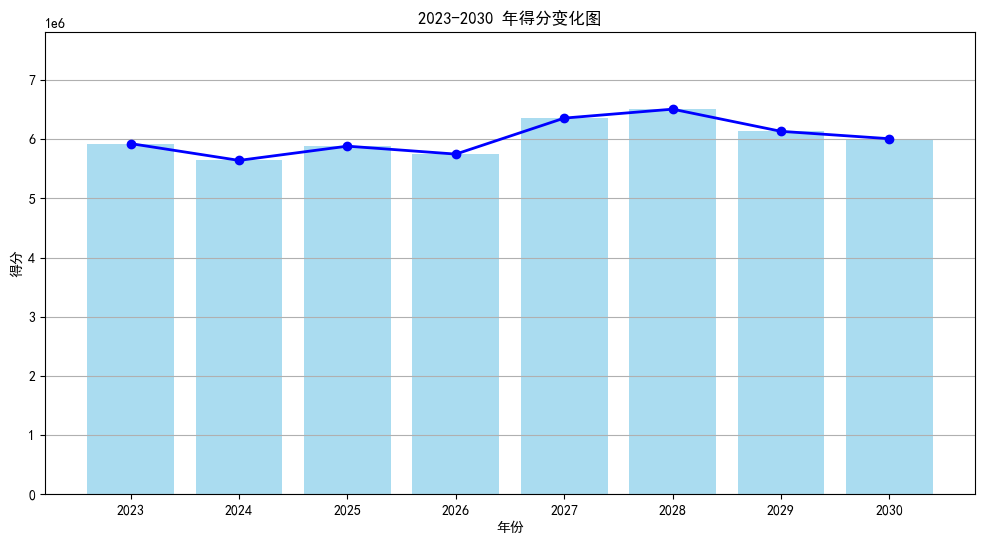

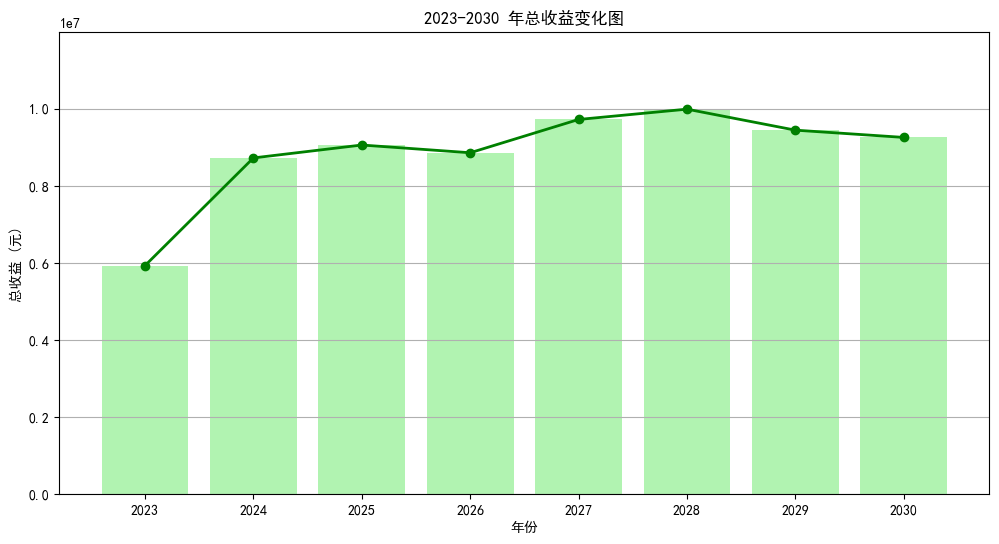

In [11]:
# 定义年份
years = [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]

# 绘制得分变化图
plt.figure(figsize=(12, 6))
plt.bar(years, scores, color='skyblue', alpha=0.7)
plt.plot(years, scores, color='blue', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('2023-2030 年得分变化图')
plt.xlabel('年份')
plt.ylabel('得分')
plt.ylim(0, max(scores) * 1.2)  # 调整纵坐标范围
plt.xticks(years)
plt.grid(axis='y')
plt.show()

# 绘制总收益变化图
plt.figure(figsize=(12, 6))
plt.bar(years, profits, color='lightgreen', alpha=0.7)
plt.plot(years, profits, color='green', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.title('2023-2030 年总收益变化图')
plt.xlabel('年份')
plt.ylabel('总收益 (元)')
plt.ylim(0, max(profits) * 1.2)  # 调整纵坐标范围
plt.xticks(years)
plt.grid(axis='y')
plt.show()

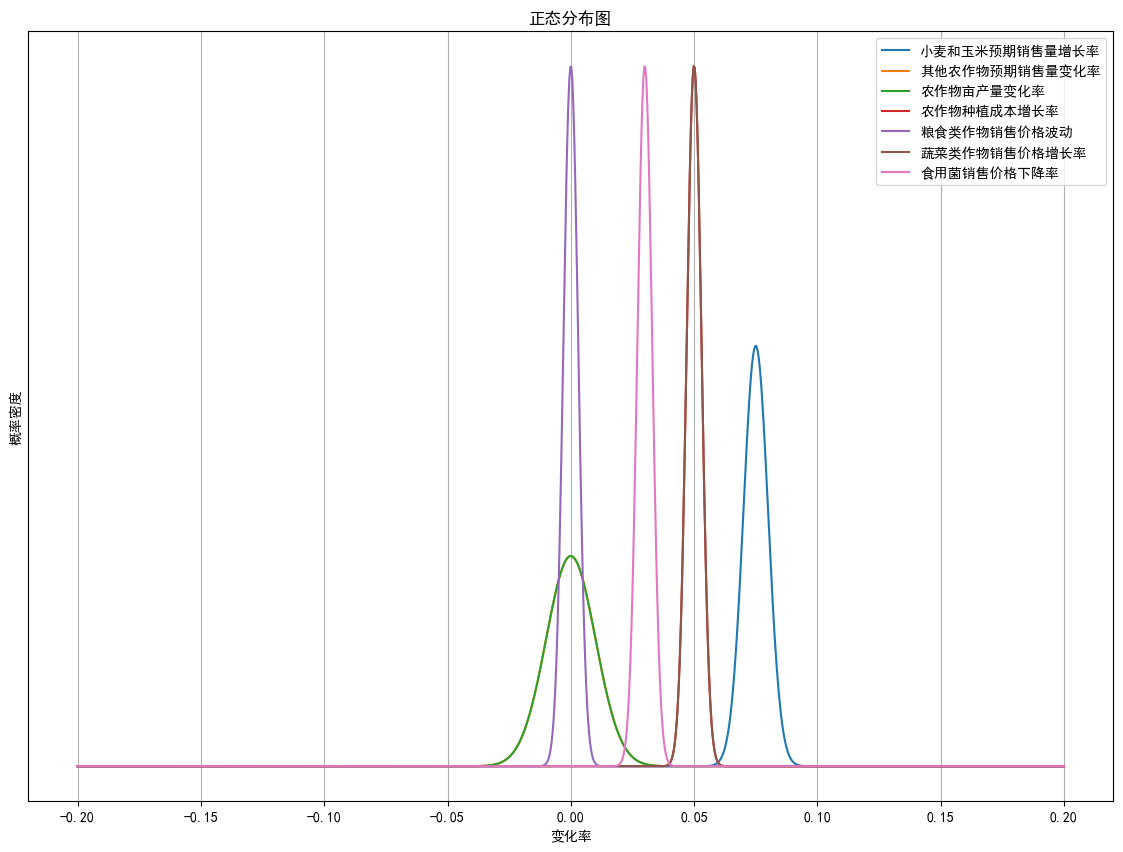

In [8]:
# 定义均值和标准差
data_info = {
    "小麦和玉米预期销售量增长率": {"mean": (0.05 + 0.10) / 2, "std": std_devs[0]},
    "其他农作物预期销售量变化率": {"mean": (0.05 - 0.05) / 2, "std": std_devs[2]},
    "农作物亩产量变化率": {"mean": (0.10 - 0.10) / 2, "std": std_devs[3]},
    "农作物种植成本增长率": {"mean": 0.05, "std": std_devs[4]},
    "粮食类作物销售价格波动": {"mean": 0, "std": std_devs[5]},
    "蔬菜类作物销售价格增长率": {"mean": 0.05, "std": std_devs[6]},
    "食用菌销售价格下降率": {"mean": (0.01 + 0.05) / 2, "std": std_devs[7]}
}

# 生成正态分布数据
x = np.linspace(-0.2, 0.2, 1000)
distributions = {key: (x, np.exp(-((x - value["mean"]) ** 2) / (2 * value["std"] ** 2)) / (value["std"] * np.sqrt(2 * np.pi))) for key, value in data_info.items()}

# 绘制正态分布图
plt.figure(figsize=(14, 10))
for key, (x, y) in distributions.items():
    plt.plot(x, y, label=key)

plt.title("正态分布图")
plt.xlabel("变化率")
plt.ylabel("概率密度")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.show()